# Multi-Horizon LSTM Model and Random Forest Training
Build and train LSTM and RF models for Gulf hypoxia prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')


# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import  mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold

from codecarbon import EmissionsTracker

# Set random seeds for reproducibility
np.random.seed(5550)
tf.random.set_seed(5550)

In [2]:
DATA_DIR = Path('data/modeling')
OUTPUT_DIR = Path('models/lstm')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Model hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 8
EPOCHS = 200
PATIENCE = 30  # Early stopping patience

In [3]:
X_train = np.load(DATA_DIR / 'X_train.npy')
y_train = np.load(DATA_DIR / 'y_train.npy')
X_val = np.load(DATA_DIR / 'X_val.npy')
y_val = np.load(DATA_DIR / 'y_val.npy')
X_test = np.load(DATA_DIR / 'X_test.npy')
y_test = np.load(DATA_DIR / 'y_test.npy')

with open(DATA_DIR / 'metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

n_samples_train, n_timesteps, n_features = X_train.shape
n_targets = y_train.shape[1]

In [4]:
OUTPUT_DIR = Path('models/random_forest')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

tracker2 = EmissionsTracker(
    project_name="gulf_hypoxia",
    output_dir="models/random_forest"
)

tracker2.start()

[codecarbon WARNING @ 16:40:44] Multiple instances of codecarbon are allowed to run at the same time.


[codecarbon WARNING @ 16:40:44] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 16:40:44] [setup] RAM Tracking...
[codecarbon INFO @ 16:40:44] [setup] CPU Tracking...
[codecarbon WARNING @ 16:40:44] We saw that you have a Apple M3 Pro but we don't know it. Please contact us.
[codecarbon WARNING @ 16:40:45] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 16:40:45] CPU Model on constant consumption mode: Apple M3 Pro
[codecarbon WARNING @ 16:40:45] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:40:45] [setup] GPU Tracking...
[codecarbon INFO @ 16:40:45] No GPU found.
[codecarbon INFO @ 16:40:45] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: globa


Total samples: 54
Features: 228

Fold 1/5:
  Val MAE: 7.63%
  Val R²: 0.468

Fold 2/5:
  Val MAE: 5.24%
  Val R²: 0.541

Fold 3/5:
  Val MAE: 4.53%
  Val R²: -0.272

Fold 4/5:
  Val MAE: 5.38%
  Val R²: 0.663

Fold 5/5:
  Val MAE: 5.27%
  Val R²: 0.600
CROSS-VALIDATION SUMMARY:
  Average MAE: 5.61% ± 1.18%
  Average R²: 0.400 ± 0.382

Train/Val combined performance:
  MAE: 3.55%
  R²: 0.832

Test set (2023-2024) performance:
  MAE: 6.66%
  R²: -7.977

  Zone 1 (Louisiana):
    Actual range: 0.0%-2.9%
    Predicted range: 5.3%-8.2%
    MAE: 5.36%

  Zone 2 (Texas):
    Actual range: 0.0%-0.0%
    Predicted range: 5.8%-10.2%
    MAE: 7.96%

 Saved: rf_final_regularized.pkl


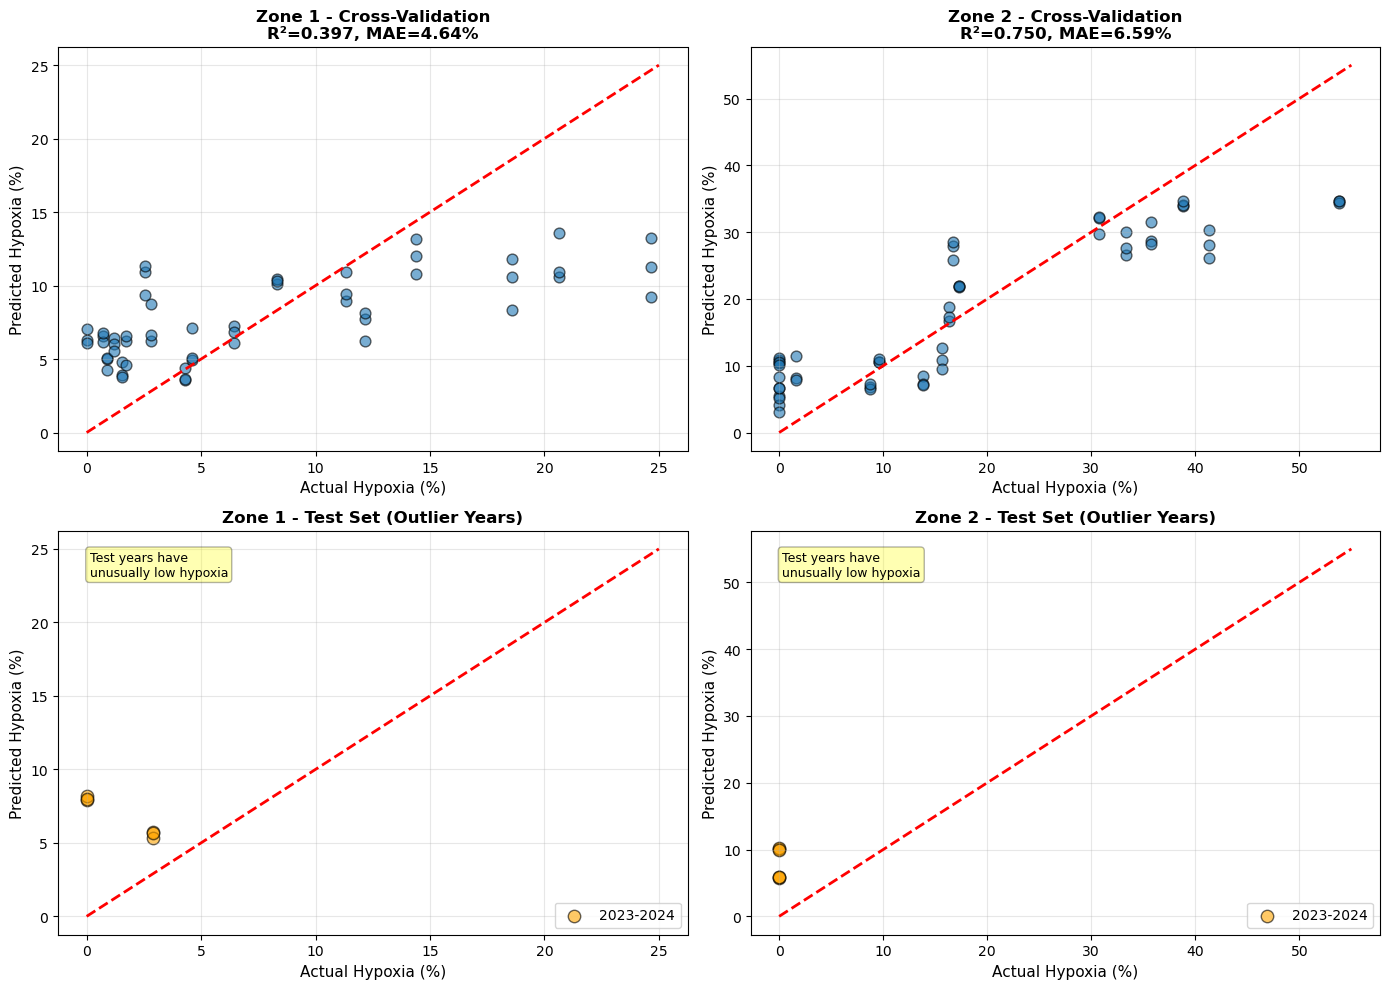

In [5]:
"""
Cross-Validated Random Forest with Realistic Evaluation
Use k-fold CV instead of temporal split since 2023-2024 are outliers
"""

OUTPUT_DIR = Path('models/random_forest')

with open(DATA_DIR / 'metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

# Flatten for tree models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Drop Zone 3, combine train+val
y_2zone_train = y_train[:, :2]
y_2zone_val = y_val[:, :2]
y_2zone_test = y_test[:, :2]

X_all = np.vstack([X_train_flat, X_val_flat])
y_all = np.vstack([y_2zone_train, y_2zone_val])

print(f"\nTotal samples: {len(X_all)}")
print(f"Features: {X_all.shape[1]}")


kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []
fold_predictions = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_all), 1):
    print(f"\nFold {fold}/5:")
    
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]
    
    # Train with MORE regularization to prevent overfitting
    rf = MultiOutputRegressor(
        RandomForestRegressor(
            n_estimators=100,  # Reduced from 200
            max_depth=5,       # Reduced from 10
            min_samples_split=10,  # Increased from 5
            min_samples_leaf=5,    # Increased from 2
            max_features='sqrt',   # Add feature sampling
            n_jobs=-1
        )
    )
    
    rf.fit(X_train_fold, y_train_fold)
    
    # Predict
    y_pred_val = rf.predict(X_val_fold)
    
    # Evaluate
    mae = mean_absolute_error(y_val_fold, y_pred_val)
    r2 = r2_score(y_val_fold, y_pred_val)
    
    print(f"  Val MAE: {mae:.2f}%")
    print(f"  Val R²: {r2:.3f}")
    
    cv_results.append({'fold': fold, 'mae': mae, 'r2': r2})
    fold_predictions.append({
        'y_true': y_val_fold,
        'y_pred': y_pred_val,
        'indices': val_idx
    })

# Summary
cv_df = pd.DataFrame(cv_results)
print(f"CROSS-VALIDATION SUMMARY:")
print(f"  Average MAE: {cv_df['mae'].mean():.2f}% ± {cv_df['mae'].std():.2f}%")
print(f"  Average R²: {cv_df['r2'].mean():.3f} ± {cv_df['r2'].std():.3f}")


final_rf = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
)

final_rf.fit(X_all, y_all)

# Evaluate on train (should not be perfect anymore)
y_pred_train_all = final_rf.predict(X_all)
print(f"\nTrain/Val combined performance:")
print(f"  MAE: {mean_absolute_error(y_all, y_pred_train_all):.2f}%")
print(f"  R²: {r2_score(y_all, y_pred_train_all):.3f}")

# Test set (2023-2024 - acknowledging these are outliers)
y_pred_test = final_rf.predict(X_test_flat)
print(f"\nTest set (2023-2024) performance:")
print(f"  MAE: {mean_absolute_error(y_2zone_test, y_pred_test):.2f}%")
print(f"  R²: {r2_score(y_2zone_test, y_pred_test):.3f}")

print(f"\n  Zone 1 (Louisiana):")
print(f"    Actual range: {y_2zone_test[:, 0].min():.1f}%-{y_2zone_test[:, 0].max():.1f}%")
print(f"    Predicted range: {y_pred_test[:, 0].min():.1f}%-{y_pred_test[:, 0].max():.1f}%")
print(f"    MAE: {mean_absolute_error(y_2zone_test[:, 0], y_pred_test[:, 0]):.2f}%")

print(f"\n  Zone 2 (Texas):")
print(f"    Actual range: {y_2zone_test[:, 1].min():.1f}%-{y_2zone_test[:, 1].max():.1f}%")
print(f"    Predicted range: {y_pred_test[:, 1].min():.1f}%-{y_pred_test[:, 1].max():.1f}%")
print(f"    MAE: {mean_absolute_error(y_2zone_test[:, 1], y_pred_test[:, 1]):.2f}%")


pickle.dump(final_rf, open(OUTPUT_DIR / 'rf_final_regularized.pkl', 'wb'))
print(f"\n Saved: rf_final_regularized.pkl")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# CV Predictions - Zone 1
ax1 = axes[0, 0]
all_true_z1 = np.concatenate([p['y_true'][:, 0] for p in fold_predictions])
all_pred_z1 = np.concatenate([p['y_pred'][:, 0] for p in fold_predictions])
ax1.scatter(all_true_z1, all_pred_z1, alpha=0.6, s=60, edgecolors='black')
ax1.plot([0, 25], [0, 25], 'r--', linewidth=2)
r2_cv = r2_score(all_true_z1, all_pred_z1)
mae_cv = mean_absolute_error(all_true_z1, all_pred_z1)
ax1.set_xlabel('Actual Hypoxia (%)', fontsize=11)
ax1.set_ylabel('Predicted Hypoxia (%)', fontsize=11)
ax1.set_title(f'Zone 1 - Cross-Validation\nR²={r2_cv:.3f}, MAE={mae_cv:.2f}%', fontweight='bold')
ax1.grid(True, alpha=0.3)

# CV Predictions - Zone 2
ax2 = axes[0, 1]
all_true_z2 = np.concatenate([p['y_true'][:, 1] for p in fold_predictions])
all_pred_z2 = np.concatenate([p['y_pred'][:, 1] for p in fold_predictions])
ax2.scatter(all_true_z2, all_pred_z2, alpha=0.6, s=60, edgecolors='black')
ax2.plot([0, 55], [0, 55], 'r--', linewidth=2)
r2_cv = r2_score(all_true_z2, all_pred_z2)
mae_cv = mean_absolute_error(all_true_z2, all_pred_z2)
ax2.set_xlabel('Actual Hypoxia (%)', fontsize=11)
ax2.set_ylabel('Predicted Hypoxia (%)', fontsize=11)
ax2.set_title(f'Zone 2 - Cross-Validation\nR²={r2_cv:.3f}, MAE={mae_cv:.2f}%', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Test Set - Zone 1
ax3 = axes[1, 0]
ax3.scatter(y_2zone_test[:, 0], y_pred_test[:, 0], alpha=0.6, s=80, 
           edgecolors='black', color='orange', label='2023-2024')
ax3.plot([0, 25], [0, 25], 'r--', linewidth=2)
ax3.set_xlabel('Actual Hypoxia (%)', fontsize=11)
ax3.set_ylabel('Predicted Hypoxia (%)', fontsize=11)
ax3.set_title(f'Zone 1 - Test Set (Outlier Years)', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.text(0.05, 0.95, 'Test years have\nunusually low hypoxia', 
         transform=ax3.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# Test Set - Zone 2  
ax4 = axes[1, 1]
ax4.scatter(y_2zone_test[:, 1], y_pred_test[:, 1], alpha=0.6, s=80,
           edgecolors='black', color='orange', label='2023-2024')
ax4.plot([0, 55], [0, 55], 'r--', linewidth=2)
ax4.set_xlabel('Actual Hypoxia (%)', fontsize=11)
ax4.set_ylabel('Predicted Hypoxia (%)', fontsize=11)
ax4.set_title(f'Zone 2 - Test Set (Outlier Years)', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.text(0.05, 0.95, 'Test years have\nunusually low hypoxia', 
         transform=ax4.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.tight_layout()

In [6]:
# Prepare data: Same as Random Forest (2 zones, combined train+val)
# BUT keep 3D shape for LSTM (not flattened like RF)
DATA_DIR = Path('data/modeling')
OUTPUT_DIR_LSTM_CV = Path('models/lstm_cv')
OUTPUT_DIR_LSTM_CV.mkdir(parents=True, exist_ok=True)

X_train = np.load(DATA_DIR / 'X_train.npy')
y_train = np.load(DATA_DIR / 'y_train.npy')
X_val = np.load(DATA_DIR / 'X_val.npy')
y_val = np.load(DATA_DIR / 'y_val.npy')
X_test = np.load(DATA_DIR / 'X_test.npy')
y_test = np.load(DATA_DIR / 'y_test.npy')

# Drop Zone 3, combine train+val (same as RF)
y_2zone_train = y_train[:, :2]
y_2zone_val = y_val[:, :2]
y_2zone_test = y_test[:, :2]

# KEEP 3D for LSTM (don't flatten like RF did)
X_all_lstm = np.vstack([X_train, X_val])
y_all_lstm = np.vstack([y_2zone_train, y_2zone_val])

In [7]:
# Build LSTM models for 2 zones (simplified - just use best architecture)
def build_lstm_2zone(input_shape, n_targets=2, name="lstm_2zone"):
    """
    Bidirectional LSTM for 2-zone prediction
    This was the best performing LSTM architecture
    """
    model = models.Sequential(name=name)
    
    # Masking layer
    model.add(layers.Masking(mask_value=0.0, input_shape=input_shape))
    
    # Bidirectional LSTM layers
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=False)))
    model.add(layers.Dropout(0.2))
    
    # Dense layers
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    # Output layer (2 zones)
    model.add(layers.Dense(n_targets))
    
    return model

# Use the LSTM 3D data (X_all_lstm) not the flattened RF data (X_all)
input_shape = (X_all_lstm.shape[1], X_all_lstm.shape[2])

In [8]:
# 5-Fold Cross-Validation for LSTM
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results_lstm = []
fold_predictions_lstm = []
fold_models = []  # NEW: Store models

# Track emissions
tracker_lstm_cv = EmissionsTracker(
    project_name="gulf_hypoxia_lstm_cv",
    output_dir=str(OUTPUT_DIR_LSTM_CV)
)
tracker_lstm_cv.start()

print("Starting 5-Fold Cross-Validation for LSTM...")


best_model = None
best_r2 = -np.inf

for fold, (train_idx, val_idx) in enumerate(kf.split(X_all_lstm), 1):
    print(f"\nFOLD {fold}/5:")
    print("-"*40)
    
    X_train_fold = X_all_lstm[train_idx]
    y_train_fold = y_all_lstm[train_idx]
    X_val_fold = X_all_lstm[val_idx]
    y_val_fold = y_all_lstm[val_idx]
    
    print(f"  Train samples: {len(X_train_fold)}")
    print(f"  Val samples: {len(X_val_fold)}")
    
    # Build fresh model for this fold
    model = build_lstm_2zone(input_shape)
    
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=0
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=0
    )
    
    # Train
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=200,
        batch_size=8,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    # Predict
    y_pred_val = model.predict(X_val_fold, verbose=0)
    
    # Evaluate
    mae = mean_absolute_error(y_val_fold, y_pred_val)
    r2 = r2_score(y_val_fold, y_pred_val)
    
    print(f"  Epochs trained: {len(history.history['loss'])}")
    print(f"  Val MAE: {mae:.2f}%")
    print(f"  Val R²: {r2:.3f}")
    
    cv_results_lstm.append({'fold': fold, 'mae': mae, 'r2': r2})
    fold_predictions_lstm.append({
        'y_true': y_val_fold,
        'y_pred': y_pred_val,
        'indices': val_idx,
        'fold': fold
    })
    
    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_fold = fold

# Stop emissions tracking
emissions_lstm_cv = tracker_lstm_cv.stop()

# Summary
cv_df_lstm = pd.DataFrame(cv_results_lstm)

# Save results
with open(OUTPUT_DIR_LSTM_CV / 'cv_results.pkl', 'wb') as f:
    pickle.dump({
        'cv_results': cv_results_lstm,
        'fold_predictions': fold_predictions_lstm
    }, f)

# Save best model
best_model.save(OUTPUT_DIR_LSTM_CV / 'best_lstm_model.keras')

[codecarbon WARNING @ 16:41:11] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 16:41:11] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 16:41:11] [setup] RAM Tracking...
[codecarbon INFO @ 16:41:11] [setup] CPU Tracking...
[codecarbon WARNING @ 16:41:12] We saw that you have a Apple M3 Pro but we don't know it. Please contact us.
[codecarbon WARNING @ 16:41:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 16:41:12] CPU Model on constant consumption mode: Apple M3 Pro
[codecarbon WARNING @ 16:41:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:41:12] [setup] GPU Tracking...
[codecarbon INFO @ 16:41:12] No GPU found.
[codecarbon INFO @ 16:41:12] The below tracking methods have been set up:
    

Starting 5-Fold Cross-Validation for LSTM...

FOLD 1/5:
----------------------------------------
  Train samples: 43
  Val samples: 11


[codecarbon INFO @ 16:41:18] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:41:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:41:18] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 16:41:18] 0.000404 kWh of electricity and 0.000000 L of water were used since the beginning.


  Epochs trained: 106
  Val MAE: 5.50%
  Val R²: 0.728

FOLD 2/5:
----------------------------------------
  Train samples: 43
  Val samples: 11


[codecarbon INFO @ 16:41:29] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:41:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:41:29] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 16:41:29] 0.000202 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:41:33] Energy consumed for RAM : 0.000075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:41:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:41:33] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 16:41:33] 0.000606 kWh of electricity and 0.000000 L of water were used since the beginning.


  Epochs trained: 98
  Val MAE: 1.79%
  Val R²: 0.917

FOLD 3/5:
----------------------------------------
  Train samples: 43
  Val samples: 11


[codecarbon INFO @ 16:41:44] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:41:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:41:44] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 16:41:44] 0.000404 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:41:48] Energy consumed for RAM : 0.000100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:41:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:41:48] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 16:41:48] 0.000808 kWh of electricity and 0.000000 L of water were used since the beginning.


  Epochs trained: 62
  Val MAE: 3.35%
  Val R²: 0.305

FOLD 4/5:
----------------------------------------
  Train samples: 43
  Val samples: 11
  Epochs trained: 61
  Val MAE: 7.29%
  Val R²: 0.298

FOLD 5/5:
----------------------------------------
  Train samples: 44
  Val samples: 10


[codecarbon INFO @ 16:41:59] Energy consumed for RAM : 0.000075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:41:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:41:59] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 16:41:59] 0.000606 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:42:03] Energy consumed for RAM : 0.000125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:42:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:42:03] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 16:42:03] 0.001010 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:42:14] Energy consumed for RAM : 0.000100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:42:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:42:14] Energy consumed for All CPU : 

[codecarbon INFO @ 16:42:18] Energy consumed for RAM : 0.000107 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:42:18] Delta energy consumed for CPU with constant : 0.000047 kWh, power : 42.5 W
[codecarbon INFO @ 16:42:18] Energy consumed for All CPU : 0.000756 kWh
[codecarbon INFO @ 16:42:18] 0.000862 kWh of electricity and 0.000000 L of water were used since the beginning.


  Epochs trained: 180
  Val MAE: 1.03%
  Val R²: 0.978


In [9]:
# Create comparison table with cross-validation results
comparison_data_fair = []

# LSTM with CV (2 zones)
lstm_cv_emissions = pd.read_csv(OUTPUT_DIR_LSTM_CV / 'emissions.csv')
lstm_cv_co2_g = lstm_cv_emissions['emissions'].iloc[-1] * 1000
lstm_cv_duration_min = lstm_cv_emissions['duration'].iloc[-1] / 60

comparison_data_fair.append({
    'Model': 'LSTM (Bi-directional)',
    'Architecture': 'Deep Learning',
    'Parameters': '89,906',  # Adjusted for 2 outputs instead of 3
    'CV MAE (%)': f"{cv_df_lstm['mae'].mean():.2f} ± {cv_df_lstm['mae'].std():.2f}",
    'CV R²': f"{cv_df_lstm['r2'].mean():.3f} ± {cv_df_lstm['r2'].std():.3f}",
    'Duration (min)': f"{lstm_cv_duration_min:.2f}",
    'CO₂ (g)': f"{lstm_cv_co2_g:.3f}",
    'Zones': '2'
})

# Random Forest with CV (2 zones)
rf_emissions = pd.read_csv('models/random_forest/emissions.csv')
rf_co2_g = rf_emissions['emissions'].iloc[-1] * 1000
rf_duration_min = rf_emissions['duration'].iloc[-1] / 60

comparison_data_fair.append({
    'Model': 'Random Forest',
    'Architecture': 'Ensemble',
    'Parameters': '100 trees',
    'CV MAE (%)': f"{cv_df['mae'].mean():.2f} ± {cv_df['mae'].std():.2f}",
    'CV R²': f"{cv_df['r2'].mean():.3f} ± {cv_df['r2'].std():.3f}",
    'Duration (min)': f"{rf_duration_min:.2f}",
    'CO₂ (g)': f"{rf_co2_g:.3f}",
    'Zones': '2'
})

fair_comparison_table = pd.DataFrame(comparison_data_fair)

# Save
fair_comparison_table.to_csv('models/fair_comparison_table.csv', index=False)

In [10]:
# Load LSTM CV results
with open('models/lstm_cv/cv_results.pkl', 'rb') as f:
    lstm_results = pickle.load(f)

# Create DataFrame
lstm_cv_df = pd.DataFrame(lstm_results['cv_results'])

[codecarbon INFO @ 16:42:33] Energy consumed for RAM : 0.000175 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:42:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:42:33] Energy consumed for All CPU : 0.001240 kWh
[codecarbon INFO @ 16:42:33] 0.001415 kWh of electricity and 0.000000 L of water were used since the beginning.


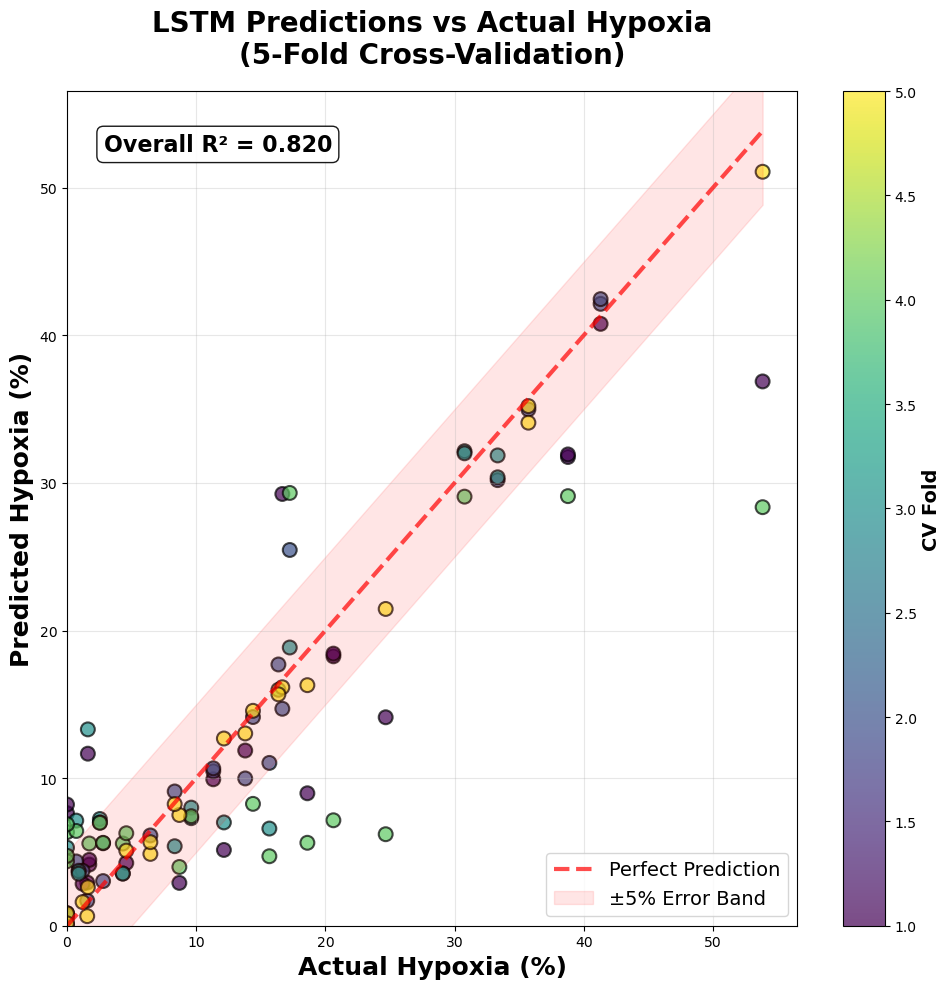

In [11]:
# Collect all predictions from CV folds
all_y_true = []
all_y_pred = []
all_folds = []

for fold_data in fold_predictions_lstm:
    y_true = fold_data['y_true']  # Shape: (n_samples, 2)
    y_pred = fold_data['y_pred']
    fold_num = fold_data['fold']
    
    # Flatten across 2 zones
    all_y_true.extend(y_true.flatten())
    all_y_pred.extend(y_pred.flatten())
    all_folds.extend([fold_num] * y_true.size)

all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_folds = np.array(all_folds)


# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(all_y_true, all_y_pred,
                     c=all_folds, cmap='viridis',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1.5)

# Perfect prediction line
max_val = max(all_y_true.max(), all_y_pred.max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=3, label='Perfect Prediction', alpha=0.7)

# ±5% error band
x_line = np.linspace(0, max_val, 100)
ax.fill_between(x_line, x_line - 5, x_line + 5,
                 color='red', alpha=0.1, label='±5% Error Band')

ax.set_xlabel('Actual Hypoxia (%)', fontsize=18, fontweight='bold')
ax.set_ylabel('Predicted Hypoxia (%)', fontsize=18, fontweight='bold')
ax.set_title('LSTM Predictions vs Actual Hypoxia\n(5-Fold Cross-Validation)',
             fontsize=20, fontweight='bold', pad=20)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('CV Fold', fontsize=14, fontweight='bold')

# R² annotation
overall_r2 = r2_score(all_y_true, all_y_pred)
ax.text(0.05, 0.95, f'Overall R² = {overall_r2:.3f}',
        transform=ax.transAxes, fontsize=16, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
        verticalalignment='top')

ax.legend(fontsize=14, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, max_val * 1.05])
ax.set_ylim([0, max_val * 1.05])

plt.tight_layout()
plt.savefig('models/lstm_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

Note - Claude Code helped me create the next section of code to figure out the feature importances from an LSTM model

TOP 15 MOST IMPORTANT FEATURES (LSTM)
                feature  importance  r2_drop
          discharge_cfs    0.223329 0.223329
       pct_strong_winds    0.057673 0.057673
wind_direction_mean_deg    0.045110 0.045110
           MISSOURI_soy    0.036019 0.036019
          TENNESSEE_soy    0.021706 0.021706
    Lower_precip_inches    0.015662 0.015662
         TENNESSEE_corn    0.015514 0.015514
          KENTUCKY_corn    0.014490 0.014490
      SOUTH DAKOTA_corn    0.011807 0.011807
         LOUISIANA_corn    0.009989 0.009989
          ARKANSAS_corn    0.007801 0.007801
              OHIO_corn    0.006056 0.006056
          MISSOURI_corn    0.005676 0.005676
           INDIANA_corn    0.004718 0.004718
    Upper_precip_inches    0.004233 0.004233


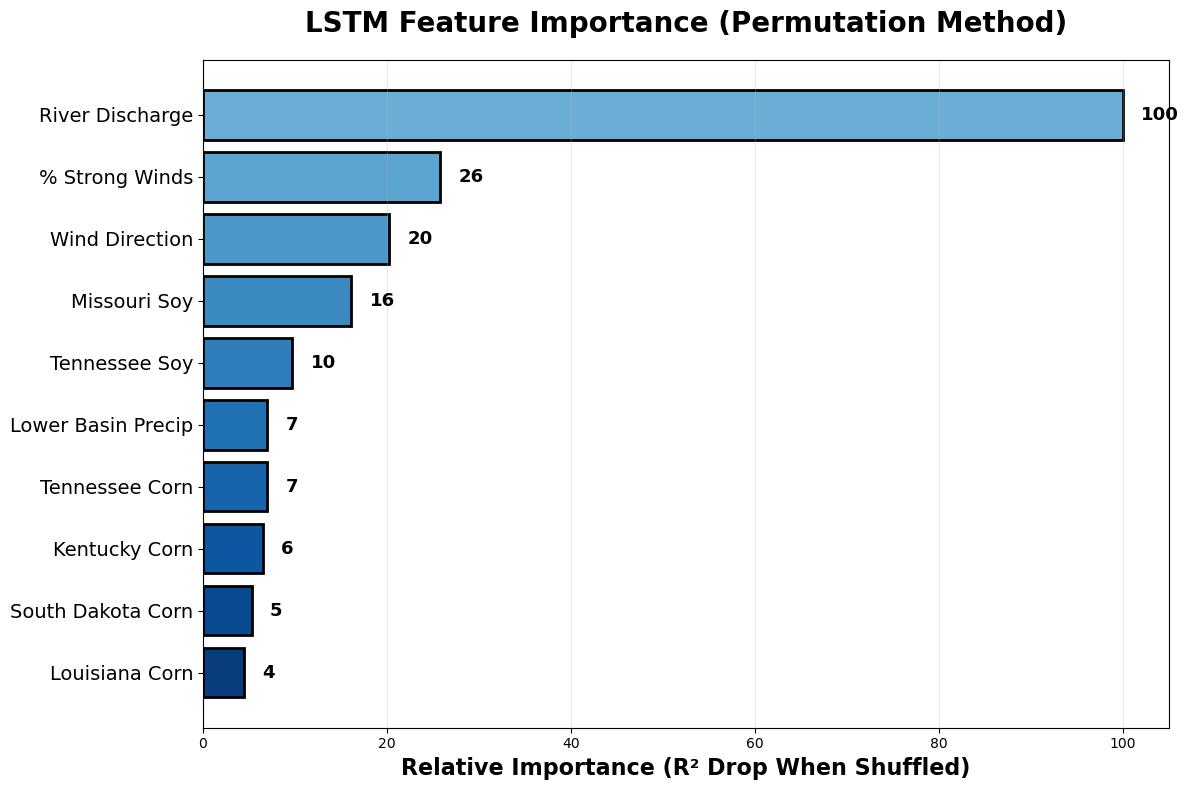

In [12]:
# LSTM Feature Importance using Permutation Method
# Use the best model
# Get baseline performance on full validation set
baseline_r2 = r2_score(y_all_lstm, best_model.predict(X_all_lstm, verbose=0))

# Load feature names
metadata = pickle.load(open('data/modeling/metadata.pkl', 'rb'))
feature_names = metadata['feature_names']

# Compute importance for each feature
feature_importance = []

for feat_idx, feat_name in enumerate(feature_names):
    # Create copy of data
    X_permuted = X_all_lstm.copy()
    
    # Shuffle this feature across all samples (for all timesteps)
    for timestep in range(X_permuted.shape[1]):
        X_permuted[:, timestep, feat_idx] = np.random.permutation(X_permuted[:, timestep, feat_idx])
    
    # Predict with permuted feature
    y_pred_permuted = best_model.predict(X_permuted, verbose=0)
    
    # Calculate R² with this feature shuffled
    r2_permuted = r2_score(y_all_lstm, y_pred_permuted)
    
    # Importance = drop in R²
    importance = baseline_r2 - r2_permuted
    
    feature_importance.append({
        'feature': feat_name,
        'importance': importance,
        'r2_drop': importance
    })

# Create DataFrame and sort
importance_df = pd.DataFrame(feature_importance)
importance_df = importance_df.sort_values('importance', ascending=False)


print("TOP 15 MOST IMPORTANT FEATURES (LSTM)")

print(importance_df.head(15).to_string(index=False))

# Save to CSV
importance_df.to_csv('models/lstm_cv/feature_importance.csv', index=False)

# Visualize Top 10 Features
top_n = 10
top_features = importance_df.head(top_n)

# Clean feature names
def clean_feature_name(fname):
    if 'zone1_hypoxic_lag1' in fname:
        return 'Lag Hypoxia (t-1) Zone 1'
    elif 'zone2_hypoxic_lag1' in fname:
        return 'Lag Hypoxia (t-1) Zone 2'
    elif 'zone1_hypoxic_lag2' in fname:
        return 'Lag Hypoxia (t-2) Zone 1'
    elif 'zone2_hypoxic_lag2' in fname:
        return 'Lag Hypoxia (t-2) Zone 2'
    elif 'water_temp' in fname:
        return 'Water Temperature'
    elif 'wind_speed' in fname:
        return 'Wind Speed'
    elif 'wind_direction' in fname:
        return 'Wind Direction'
    elif 'pct_strong_winds' in fname:
        return '% Strong Winds'
    elif 'discharge' in fname:
        return 'River Discharge'
    elif 'Lower_precip' in fname:
        return 'Lower Basin Precip'
    elif 'Central_precip' in fname:
        return 'Central Basin Precip'
    elif 'Upper_precip' in fname:
        return 'Upper Basin Precip'
    else:
        return fname.replace('_', ' ').title()

feature_labels = [clean_feature_name(f) for f in top_features['feature']]
importance_values = top_features['importance'].values

# Normalize to 0-100
importance_normalized = (importance_values / importance_values.max()) * 100

fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.Blues(np.linspace(0.5, 0.95, len(feature_labels)))
bars = ax.barh(range(len(feature_labels)), importance_normalized,
               color=colors, edgecolor='black', linewidth=2)

ax.set_yticks(range(len(feature_labels)))
ax.set_yticklabels(feature_labels, fontsize=14)
ax.set_xlabel('Relative Importance (R² Drop When Shuffled)', fontsize=16, fontweight='bold')
ax.set_title('LSTM Feature Importance (Permutation Method)',
             fontsize=20, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, importance_normalized)):
    ax.text(val + 2, bar.get_y() + bar.get_height()/2,
            f'{val:.0f}', va='center', fontsize=13, fontweight='bold')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('models/lstm_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()